# qa-nlp
Question answering neural model based on the SQuAD dataset.

Authors:
- Lorenzo Mario Amorosa
- Andrea Espis
- Mattia Orlandi
- Giacomo Pinardi

## 0. Environment setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [27]:
# Library to read json
import json

# Numeric and data manipulation tools
import pandas as pd
import numpy as np
import random

# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Natural language tools
import gensim
import gensim.downloader as gloader

# Other tools
from tqdm.notebook import tqdm
import collections
from collections import OrderedDict, Counter
from time import time
from itertools import zip_longest

# automatic mixed precision training:
from torch.cuda.amp import autocast 
from torch.cuda.amp import GradScaler

# Type hint
from typing import Optional, Callable, Tuple, Dict, List, Union

# bert
from transformers import AlbertTokenizerFast, XLNetTokenizerFast
from model.albert_squad import AlbertForQuestionAnswering
from utils.xlnet_train_utils import training_loop

# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using this device:', DEVICE)

if not(torch.cuda.is_available()):
    raise Exception('Switch to runtime GPU, otherwise the code won\'t work properly')

Using this device: cuda:0


In [5]:
# Set seed for reproducibility
def fix_random(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [15]:
# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using this device:", DEVICE)

# Define special tokens
PAD = '<PAD>'
UNK = '<UNK>'

model_name = 'albert-xlarge-v1'

using this device: cuda:0


In [7]:
# Lambda for computing the mean of a list
mean: Callable[[List[float]], float] = lambda l: sum(l) / len(l)

# Lambda for transforming a list of tuples into a tuple of lists
to_tuple_of_lists: Callable[[List[Tuple]], Tuple[List]] = lambda list_of_tuples: tuple(map(list, zip(*list_of_tuples)))

# Lambda for transforming a tuple of lists into a list of tuples
to_list_of_tuples: Callable[[Tuple[List]], List[Tuple]] = lambda tuple_of_lists: list(zip(*tuple_of_lists))

# Lambda for iterating with batches (if the length of the sequences does not match with the batch size, tuples of empty lists are appended)
batch_iteration: Callable[[List[Tuple]], zip] = lambda data, batch_size: zip_longest(*[iter(data)] * batch_size, fillvalue=([], [], []))

## 1. Dataset preparation

In [8]:
"""
json structure:

data []
|---title
|---paragraphs []
|   |---context
|   |---qas []
|   |   |---answers []
|   |   |   |---answer_start
|   |   |   |---text
|   |   |---question
|   |   |---id
version

"""

filename = 'training_set.json'

with open(filename, 'r') as f:
    raw_data = f.readlines()[0]

parsed_data = json.loads(raw_data)['data']

context_list = []
context_index = -1
paragraph_index = -1

dataset = {'paragraph_index': [], 'context_index': [], 'question': [], 'id': [], 'answer_start': [], 'answer_end': [], 'answer_text': []}

for i in range(len(parsed_data)):
    paragraph_index += 1
    for j in range(len(parsed_data[i]['paragraphs'])):
        context_list.append(parsed_data[i]['paragraphs'][j]['context'])
        context_index += 1

        for k in range(len(parsed_data[i]['paragraphs'][j]['qas'])):
            question = parsed_data[i]['paragraphs'][j]['qas'][k]['question']
            id = parsed_data[i]['paragraphs'][j]['qas'][k]['id']

            for l in range(len(parsed_data[i]['paragraphs'][j]['qas'][k]['answers'])): 
                answer_start = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['answer_start']
                answer_text = parsed_data[i]['paragraphs'][j]['qas'][k]['answers'][l]['text']

                answer_end = answer_start + len(answer_text)

                dataset['paragraph_index'].append(paragraph_index)
                dataset['context_index'].append(context_index)
                dataset['question'].append(question)
                dataset['id'].append(id)
                dataset['answer_start'].append(answer_start)
                dataset['answer_end'].append(answer_end)
                dataset['answer_text'].append(answer_text)

df = pd.DataFrame.from_dict(dataset)

df.head()

,paragraph_index,context_index,question,id,answer_start,answer_end,answer_text
0,0,0,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,515,541,Saint Bernadette Soubirous
1,0,0,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,188,213,a copper statue of Christ
2,0,0,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,279,296,the Main Building
3,0,0,What is the Grotto at Notre Dame?,5733be284776f41900661181,381,420,a Marian place of prayer and reflection
4,0,0,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,92,126,a golden statue of the Virgin Mary


In [9]:
# L'unica cosa che si potrebbe rimuovere è la fonetica, ma è poco presente. Inoltre facendolo bisognerebbe aggiornare gli indici

# Some examples of contexts and questions:
for i in range(0, 4000, 100):
    # print('Title:   ', title_list[df['title_index'][i]])
    print('Context: ', context_list[df['context_index'][i]])
    print('Question:', df['question'][i], "\n")

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? 

Context:  One of the main driving forces in the growth of the University was its football team, the Notre Dame Fighting Irish. Knute Rockne became head coach in 1918. Under Rockne, the Irish would post a record

In [10]:
# Define split ratios
test_ratio = 0.2
val_ratio = 0.2

# Build array of paragraphs indexes and shuffle them
paragraph_indexes = df['paragraph_index'].unique()
np.random.shuffle(paragraph_indexes)
n_samples = len(paragraph_indexes)

# Reserve indexes for test set
test_size = int(test_ratio * n_samples)
train_val_size = n_samples - test_size
test_indexes = paragraph_indexes[-test_size:]
# Reserve indexes for validation set
val_size = int(val_ratio * train_val_size)
train_size = train_val_size - val_size
val_indexes = paragraph_indexes[-(test_size + val_size):-test_size]
# Reserve indexes for training set
train_indexes = paragraph_indexes[:train_size]

assert train_size == len(train_indexes), 'Something went wrong with train set slicing'
assert val_size == len(val_indexes), 'Something went wrong with val set slicing'
assert test_size == len(test_indexes), 'Something went wrong with test set slicing'

print('Number of train paragraphs:', train_size)
print('Number of validation paragraphs:', val_size)
print('Number of test paragraphs:', test_size)

# Split dataframe
df_train = df[np.in1d(df['paragraph_index'], train_indexes)].reset_index(drop=True)
df_val = df[np.in1d(df['paragraph_index'], val_indexes)].reset_index(drop=True)
df_test = df[np.in1d(df['paragraph_index'], test_indexes)].reset_index(drop=True)

print('\nNumber of train samples:', len(df_train))
print('Number of validation samples:', len(df_val))
print('Number of test samples:', len(df_test))

# Obtaining list of ids for accurate performance evaluation
id_train = df_train['id'].to_list()
id_val = df_val['id'].to_list()
id_test = df_test['id'].to_list()

Number of train paragraphs: 284
Number of validation paragraphs: 70
Number of test paragraphs: 88

Number of train samples: 57451
Number of validation samples: 12921
Number of test samples: 17227


## 2. Embeddings

In [11]:
if True:
    df_train = pd.concat([df_train , df_val], axis=0) 
    df_val = df_test
    
if True:
    df_train = df_train[:100]
    df_val = df_val[:30]

In [45]:
tokenizer = AlbertTokenizerFast.from_pretrained(model_name)
# tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')

In [53]:
def align_labels(df: pd.DataFrame, context_list: List[str]):   
    # Retrieve contexts
    contexts = df['context_index'].apply(lambda x: context_list[x])
    # Get indexes to start_end characters
    y_char = [(start, end) for start, end in zip(df['answer_start'].tolist(), df['answer_end'].tolist())]
    # Tokenize context to obtain correspondence
    offset_mapping = [tokenizer.encode_plus(context, return_offsets_mapping=True, truncation=True)['offset_mapping'] for context in contexts]
    # Convert indexes s.t. they point to start/end tokens
    y_aligned = []
    for offset, (char_start, char_end) in zip(offset_mapping, y_char):
        token_start, token_end = None, None
        for i, span in enumerate(offset):
            if span[0] <= char_start <= span[1]:
                token_start = i
            if span[0] <= char_end <= span[1]:
                token_end = i
                break
        y_aligned.append((token_start, token_end))
    
    return contexts.tolist(), df['question'].tolist(), y_aligned

train_data = to_list_of_tuples(align_labels(df_train, context_list))
val_data = to_list_of_tuples(align_labels(df_val, context_list))
test_data = to_list_of_tuples(align_labels(df_test, context_list))
# ignore warning

In [54]:
shuffled_train_data = random.Random(42).sample(train_data, len(train_data))

for idx in range(10):
    # Get sample
    context, question, (token_start, token_end) = shuffled_train_data[idx]
    # Tokenize question and context
    input_ids = tokenizer(question, context, truncation='only_second')['input_ids']
    # Reconvert ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # Find context offset
    offset = input_ids.index(tokenizer.sep_token_id)
    # Update start and end labels
    token_start += offset
    token_end += offset
    # Extract answer's tokens
    answer_tokens = tokens[token_start:token_end + 1]
    # Format answer
    answer = ''.join(answer_tokens).replace('▁', ' ').strip()

    print(question, ':', answer)

What amount of the graduate student body at Notre Dame live on the campus? : 20%
Which prize did Frederick Buechner create? : buechner prize for preaching
What is the Grotto at Notre Dame? : a marian place of prayer and reflection
Which college did Notre Dame add in 1921? : college of commerce
What is the name of the main library at Notre Dame? : theodore m. hesburgh library
In what year was the Joan B. Kroc Institute for International Peace Studies founded? : 1986
Which department at Notre Dame is the only one to not offer a PhD program? : department of pre-professional studies
Before the creation of the College of Engineering similar studies were carried out at which Notre Dame college? : the college of science
What individuals live at Fatima House at Notre Dame? : retired priests and brothers
How many chapels are on the Notre Dame campus? : fifty-seven


## 3. Training


In [55]:
# model creation
albert = AlbertForQuestionAnswering(model_name).to(DEVICE)

In [56]:
from utils.squad_utils import squad_loss

In [58]:
EP = 2
BS = 8

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, albert.parameters()))
criterion = squad_loss

history = training_loop(model = albert,
                        train_data = train_data,
                        optimizer = optimizer,
                        epochs = EP,
                        batch_size = BS,
                        criterion = criterion,
                        tokenizer = tokenizer,
                        val_data = val_data,
                        early_stopping = True,
                        patience = 15,
                        checkpoint_path='albert_baseline.pt')

plot_history(history, "history_albert")

----------------------------------------------------------------------------------------------------
Epoch 1/2


Start_pred: 153, End_pred: 205, Start_true: 184, End_true: 184
	Loss: 10.84017 - Distance start: 79.86 - Distance end: 90.05exact_score: 0.00 f1_score: 0.08[Time elapsed: 51.11 s]


Start (p): 90, End (p): 108, Start (T): 78, End (T): 82
	Validation loss: 10.27913 - Distance start: 48.37 - Distance end: 48.70 exact_score: 0.00 f1_score: 0.10[Time elapsed: 11.33 s]
----------------------------------------------------------------------------------------------------
Epoch 2/2


Start_pred: 153, End_pred: 269, Start_true: 184, End_true: 184
	Loss: 9.60086 - Distance start: 59.91 - Distance end: 80.73exact_score: 0.01 f1_score: 0.10[Time elapsed: 53.90 s]


Start (p): 13, End (p): 38, Start (T): 78, End (T): 82
	Validation loss: 10.13441 - Distance start: 74.30 - Distance end: 58.30 exact_score: 0.00 f1_score: 0.06[Time elapsed: 11.47 s]


NameError: name 'plot_history' is not defined

In [25]:
from utils.bidaf_train_utils import training_loop

import matplotlib.pyplot as plt
%matplotlib inline
 

def plot_history(history):    
    # this function is simply used to plot and save the image (and the dictionary) about the train and val loss and accuracy during the training
    
    
    fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))
    plt.suptitle('loss', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.])

    axes.plot(history['loss'], label='train_loss')
    axes.plot(history['val_loss'], label='val_loss')
    axes.set_title('loss')
    axes.set(xlabel='# Epochs')
    axes.grid()
    axes.legend();

    fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('scores', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['exact_score'], label='train_exact_score')
    axes[0].plot(history['val_exact_score'], label='val_exact_score')
    axes[0].set_title('exact_score')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['f1_score'], label='train_f1_score')
    axes[1].plot(history['val_f1_score'], label='val_f1_score')
    axes[1].set_title('f1_score')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();
    
    fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('distances', size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    axes[0].plot(history['distance_end'], label='train_distance_end')
    axes[0].plot(history['val_distance_end'], label='val_distance_end')
    axes[0].set_title('distance_end')
    axes[0].set(xlabel='# Epochs')
    axes[0].grid()
    axes[0].legend();

    axes[1].plot(history['distance_start'], label='train_distance_start')
    axes[1].plot(history['val_distance_start'], label='val_distance_start')
    axes[1].set_title('distance_start')
    axes[1].set(xlabel='# Epochs')
    axes[1].grid()
    axes[1].legend();

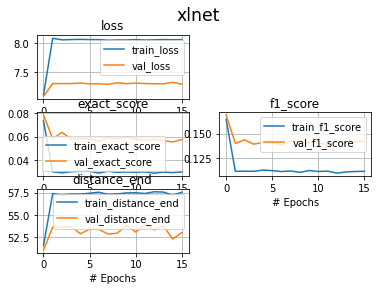

In [24]:
plot_history(history)